## PGD BLACK-BOX ATTACK

In [2]:
from __future__ import print_function
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from drive.MyDrive.TrustworthyML.MNIST_BlackBox_Attack.small_cnn import *
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    #1*1*28*28
    self.conv1=nn.Conv2d(1,10,5)
    self.conv2=nn.Conv2d(10,20,3)
    self.fc1=nn.Linear(20*10*10,500)
    self.fc2=nn.Linear(500,10)

  def forward(self,x):
    in_size=x.size(0)
    out=self.conv1(x)#1*10*24*24
    out=F.relu(out)
    out=F.max_pool2d(out,2,2)
    out=self.conv2(out)
    out=F.relu(out)
    out=out.view(in_size,-1)
    out=self.fc1(out)
    out=F.relu(out)
    out=self.fc2(out)
    out=F.log_softmax(out,dim=1)
    return out

In [4]:
epsilon=0.3
num_steps=10
step_sizes=[.016,.032,.040,.048,.056]
model_target_path="/content/drive/MyDrive/TrustworthyML/MNIST_BlackBox_Attack/MNIST_small_cnn.checkpoint（副本）"
use_cuda=True

In [5]:
dataset=datasets.MNIST(root='../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),]))
data=torch.tensor(dataset.data[:10000].float()).unsqueeze(1)
data=(data-data.min())/(data.max()-data.min())
train_ds=TensorDataset(data,dataset.targets[:10000])
test_loader=torch.utils.data.DataLoader(train_ds,batch_size=1,shuffle=True)
device=torch.device("cuda")
model_target=SmallCNN().to(device)
checkpoint=torch.load(model_target_path,map_location=torch.device('cuda'))
model_target.load_state_dict(checkpoint['state_dict'])
model_target.eval()
model_source=ConvNet().to(device)
model_state_dict=torch.load('/content/drive/MyDrive/TrustworthyML/MNIST_BlackBox_Attack/model.pth')
model_source.load_state_dict(model_state_dict)
model_source.eval()

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


ConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [6]:
def _pgd_blackbox(model_source,X,y,epsilon,num_steps,step_size):
    
    X_pgd = Variable(X.data, requires_grad=True)
    
    random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device)
    X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)

    for i in range(num_steps):
        opt = optim.SGD([X_pgd], lr=1e-3)
        opt.zero_grad()

        with torch.enable_grad():
            loss = nn.CrossEntropyLoss()(model_source(X_pgd), y)
        loss.backward()
        eta = step_size * X_pgd.grad.data.sign()
        X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
        eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
        X_pgd = Variable(X.data + eta, requires_grad=True)
        X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)

    return X_pgd

In [7]:
def test(model_target,model_source, device, test_loader):
    correct=0
    adv_examples=[]

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad=True
        output = model_target(data)
        init_pred=output.max(1,keepdim=True)[1]
        if init_pred.item()!=target.item():
            continue
        # pgd attack
        X, y = Variable(data, requires_grad=True), Variable(target)
        X_pgd=_pgd_blackbox(model_source, X, y,epsilon,num_steps,step_size)

        output=model_target(X_pgd)
        final_pred=output.max(1,keepdim=True)[1]
        if final_pred.item()==y.item():
            correct+=1
        else:
            if len(adv_examples)<5:
                adv_ex=X_pgd.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(),final_pred.item(),adv_ex))
        
    final_acc=correct/float(len(test_loader))
    success_rate=float(len(test_loader)-correct)/float(len(test_loader))
    print("Step Size: {}\tTest Accuracy={}/{}={}\tSuccess Rate={}".format(step_size,correct,len(test_loader),final_acc,success_rate))
    return final_acc,adv_examples

In [8]:
accuracies=[]
examples=[]

for step_size in step_sizes:
    ac,ex=test(model_target,model_source, device, test_loader)
    accuracies.append(ac)
    examples.append(ex)

Step Size: 0.016	Test Accuracy=9434/10000=0.9434	Success Rate=0.0566
Step Size: 0.032	Test Accuracy=7061/10000=0.7061	Success Rate=0.2939
Step Size: 0.04	Test Accuracy=6251/10000=0.6251	Success Rate=0.3749
Step Size: 0.048	Test Accuracy=5882/10000=0.5882	Success Rate=0.4118
Step Size: 0.056	Test Accuracy=5710/10000=0.571	Success Rate=0.429


In [13]:
step_size=0.07
ac,ex=test(model_target,model_source, device, test_loader)
accuracies.append(ac)
examples.append(ex)

Step Size: 0.07	Test Accuracy=5437/10000=0.5437	Success Rate=0.4563


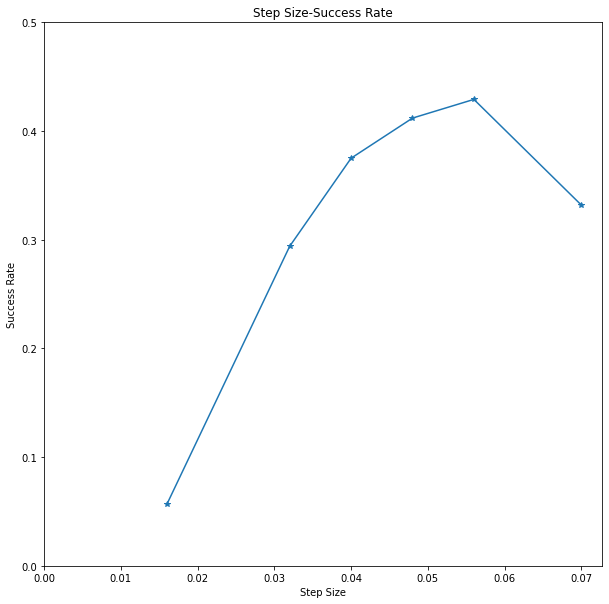

In [21]:
temp=[1,1,1,1,1,1]
final=[0,0,0,0,0,0]
for i in range(6):
  final[i]=temp[i]-accuracies[i]

plt.figure(figsize=(10,10))
plt.plot([0.016, 0.032, 0.04, 0.048, 0.056,0.070],final,"*-")
plt.yticks(np.arange(0,0.6,step=0.1))
plt.xticks(np.arange(0,.08,step=.01))
plt.title("Step Size-Success Rate")
plt.xlabel("Step Size")
plt.ylabel("Success Rate")
plt.show()

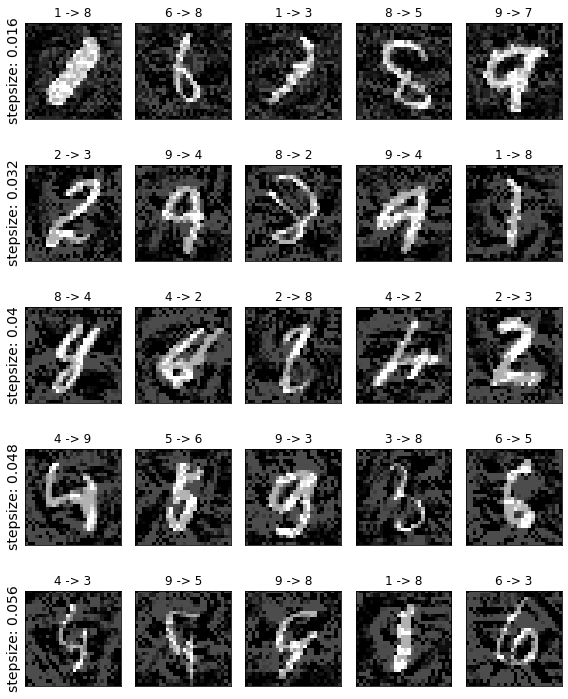

In [10]:
cnt=0
plt.figure(figsize=(8,10))
for i in range(len(step_sizes)):
  for j in range(len(examples[i])):
    cnt+=1
    plt.subplot(len(step_sizes),len(examples[0]),cnt)
    plt.xticks([],[])
    plt.yticks([],[])
    if j==0:
      plt.ylabel("stepsize: {}".format(step_sizes[i]),fontsize=14)
    orig,adv,ex=examples[i][j]
    plt.title("{} -> {}".format(orig,adv))
    plt.imshow(ex,cmap="gray")
plt.tight_layout()
plt.show()